In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

import numbers
import graphviz
import networkx as nx
import semopy
import subprocess
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.base import clone as sk_clone
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.metrics import f1_score, roc_auc_score

from itertools import product

from scipy.io import arff

from math import sqrt
from joblib import Parallel, delayed

import lingam
from lingam import DirectLiNGAM

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

from tqdm import tqdm
import openml

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes = 1, dropout=0.2):
        super(MLP, self).__init__()
        self.fc0 = nn.Linear(input_size, 64)
        # self.fc00 = nn.Linear(64, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
#         self.fc3_2 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(8, num_classes)
        self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.relu(self.fc0(x))
#         x = self.dropout(x)
        # x = self.relu(self.fc00(x))
#         x = self.dropout(x)
        x = self.relu(self.fc1(x))
#         x = self.dropout(x)
        x = self.relu(self.fc2(x))
#         x = self.dropout(x)
        x = self.relu(self.fc3(x))
#         x = self.relu(self.fc3_2(x))
#         x = self.dropout(x)
        x = self.fc4(x)
        return x

In [5]:
def train_on_full_data(
    col, X, y, model_class, input_size,
    epochs=500, batch_size=64, lr=0.001, progress_bar=True, weight=None, regularization="l2", reg_lambda=0.001
):
    """
    Train a PyTorch model on the full dataset and track two models:
    1. Early stopping based on accuracy.
    2. Model with the lowest loss.

    After each epoch, check and update both models if criteria are met and log the best accuracy and loss.

    Parameters:
    X : np.ndarray
        Standardized features.
    y : np.ndarray
        Preprocessed label vector.
    model_class : class
        PyTorch model class (e.g., MLP).
    input_size : int
        Number of input features.
    epochs : int
        Number of epochs for training the PyTorch model.
    batch_size : int
        Batch size for training.
    lr : float
        Learning rate for the optimizer.
    progress_bar : bool
        Whether to display a progress bar.
    weight : torch.Tensor or None
        Class weights for weighted cross-entropy.
    regularization : str
        Type of regularization ("l1" or "l2").
    reg_lambda : float
        Regularization strength.

    Returns:
    dict
        Dictionary containing the best models, their respective datasets with logits, and all epoch metrics.
    """

    X_tensor = torch.tensor(X, dtype = torch.float32)
    y_tensor = torch.tensor(y, dtype = torch.float32)
    print(X_tensor.shape, y_tensor.shape)

    train_dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

    model = model_class(input_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if weight is not None:
        weight_tensor = torch.tensor(weight, dtype=torch.float32)
        weight_tensor = weight.clone().detach().float()
        criterion = nn.BCEWithLogitsLoss(pos_weight=weight_tensor)
    else:
        criterion = nn.BCEWithLogitsLoss()

    # Tracking metrics
    best_acc = 0
    best_loss = float("inf")
    best_acc_state = None
    best_loss_state = None
    epoch_losses = []
    epoch_accuracies = []
    step_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            base_loss = criterion(outputs, batch_y)

            if regularization == "l1":
                reg_loss = reg_lambda * sum(torch.sum(torch.abs(param)) for param in model.parameters())
            elif regularization == "l2":
                reg_loss = reg_lambda * sum(torch.sum(param ** 2) for param in model.parameters())
            else:
                reg_loss = 0
#                 raise ValueError("Invalid regularization type. Choose 'l1' or 'l2'.")

            loss = base_loss + reg_loss

            loss.backward()
            optimizer.step()

            step_losses.append(loss.item())
            epoch_loss += loss.item()
            logits = torch.sigmoid(outputs)
            predictions = (logits > 0.5).float()
            correct += (predictions == batch_y).sum().item()
            total += batch_y.size(0)

        epoch_loss /= len(train_loader)
        accuracy = correct / total

        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(accuracy)

        if accuracy > best_acc:
            best_acc = accuracy
            best_acc_state = model.state_dict()
        if best_acc > 0.9:
            break

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_loss_state = model.state_dict()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Best Accuracy: {best_acc:.4f}, Lowest Loss: {best_loss:.4f}")

    # Load the best accuracy model and compute logits
    model.load_state_dict(best_acc_state)
    with torch.no_grad():
        logits_acc = torch.sigmoid(model(X_tensor).squeeze()).numpy()

    updated_df = pd.DataFrame(X, columns=col)
    updated_df["mlp_acc"] = logits_acc.reshape(-1, 1)
    # print(updated_df.shape)
#     updated_df["mlp_loss"] = logits_loss.reshape(-1, 1)
    # print(len(y))
    updated_df["class"] = y
    # print(updated_df["class"].isna().sum())

    results = {
        "best_accuracy_model": best_acc_state,
#         "best_loss_model": best_loss_state,
        "updated_dataset": updated_df,
        "epoch_metrics": {
            "train_losses": epoch_losses,
            "train_accuracies": epoch_accuracies
        },
        "step_losses": step_losses
    }

    return results, updated_df

In [6]:
def calculate_class_weights(y):
    """
    Calculate class weights for binary classification based on the distribution of labels.

    Parameters:
    y : np.ndarray
        Array of binary labels.

    Returns:
    float
        Weight for the positive class.
    """
    
    class_counts = np.bincount(y)
    total_samples = len(y)

    weight_for_positive = total_samples / (2 * class_counts[1])
    weight_for_negative = total_samples / (2 * class_counts[0])

    return weight_for_positive, weight_for_negative

In [7]:
def plot_step_loss(step_losses, save_path="loss_vs_steps.png"):
    """
    Plot and save the loss curve over steps.

    Parameters:
    step_losses : list
        List of step-wise losses during training.
    save_path : str
        Path to save the plot image.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(step_losses)), step_losses, label="Step Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Loss vs Steps")
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

In [37]:
### uci gallstone datasets example

gallstone = pd.read_csv('gallstone/dataset-uci.csv')

In [38]:
gallstone.shape

(319, 39)

In [39]:
#### we did'nt consider the comorbidity information in the dataset.

gallstone_use = gallstone[gallstone['Comorbidity'] == 0].drop(columns = ['Comorbidity', 'Coronary Artery Disease (CAD)', 'Hypothyroidism', 'Hyperlipidemia', 'Diabetes Mellitus (DM)'])
gallstone_use

,Gallstone Status,Age,Gender,Height,Weight,Body Mass Index (BMI),Total Body Water (TBW),Extracellular Water (ECW),Intracellular Water (ICW),Extracellular Fluid/Total Body Water (ECF/TBW),...,High Density Lipoprotein (HDL),Triglyceride,Aspartat Aminotransferaz (AST),Alanin Aminotransferaz (ALT),Alkaline Phosphatase (ALP),Creatinine,Glomerular Filtration Rate (GFR),C-Reactive Protein (CRP),Hemoglobin (HGB),Vitamin D
0,0,50,0,185,92.8,27.1,52.9,21.2,31.7,40.00,...,40.0,134.0,20.0,22.0,87.0,0.82,112.47,0.0,16.0,33.0
2,0,61,0,171,91.1,31.2,47.2,20.1,27.1,43.00,...,43.0,69.0,18.0,14.0,66.0,1.25,65.51,0.0,16.2,30.2
3,0,41,0,168,67.7,24.0,41.4,17.0,24.4,41.00,...,59.0,53.0,20.0,12.0,34.0,1.02,94.10,0.0,15.4,35.4
4,0,42,0,178,89.6,28.3,51.4,20.0,31.4,39.00,...,30.0,326.0,27.0,54.0,71.0,0.82,112.47,0.0,16.8,40.6
5,0,96,0,155,49.0,20.4,34.0,15.7,18.3,46.00,...,30.0,65.0,13.0,13.0,60.0,1.46,43.74,0.0,11.0,45.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,1,49,0,178,88.8,28.0,47.6,20.0,28.0,42.01,...,55.0,81.0,28.0,50.0,90.0,0.98,94.50,6.2,16.5,8.3
315,1,31,1,157,53.4,21.7,29.3,12.3,17.0,42.00,...,58.0,64.0,24.0,16.0,38.0,0.50,128.50,0.0,12.5,24.0
316,1,58,0,172,96.6,32.7,49.2,21.0,28.2,43.00,...,45.0,168.0,21.0,27.0,94.0,1.04,83.23,0.0,15.4,15.7
317,1,37,1,177,88.4,28.2,50.2,19.9,30.3,40.00,...,33.0,253.0,40.0,22.0,115.0,1.01,98.23,0.4,16.0,33.3


In [40]:
#### separate the gender group with in the dataset

gallstone_male = gallstone_use[gallstone_use['Gender'] == 0].drop(columns = ['Gender'])
gallstone_female = gallstone_use[gallstone_use['Gender'] == 1].drop(columns = ['Gender'])

In [41]:
print(gallstone_male.shape, gallstone_female.shape)

(110, 33) (107, 33)


In [42]:
epochs = 1000
batch_size = 128
lr = 0.001
regularization=None#"l2"#
reg_lambda=None#0.1#

Numerical features missing rate: 0.0
Class weights: tensor([0.5794, 0.4206])
torch.Size([107, 32]) torch.Size([107])
Epoch 1/1000, Loss: 0.9933, Accuracy: 0.4206, Best Accuracy: 0.4206, Lowest Loss: 0.9933
Epoch 2/1000, Loss: 0.8111, Accuracy: 0.4299, Best Accuracy: 0.4299, Lowest Loss: 0.8111
Epoch 3/1000, Loss: 0.7246, Accuracy: 0.3832, Best Accuracy: 0.4299, Lowest Loss: 0.7246
Epoch 4/1000, Loss: 0.7002, Accuracy: 0.4393, Best Accuracy: 0.4393, Lowest Loss: 0.7002
Epoch 5/1000, Loss: 0.6984, Accuracy: 0.5234, Best Accuracy: 0.5234, Lowest Loss: 0.6984
Epoch 6/1000, Loss: 0.6945, Accuracy: 0.5421, Best Accuracy: 0.5421, Lowest Loss: 0.6945
Epoch 7/1000, Loss: 0.6917, Accuracy: 0.5514, Best Accuracy: 0.5514, Lowest Loss: 0.6917
Epoch 8/1000, Loss: 0.6867, Accuracy: 0.5794, Best Accuracy: 0.5794, Lowest Loss: 0.6867
Epoch 9/1000, Loss: 0.6807, Accuracy: 0.5794, Best Accuracy: 0.5794, Lowest Loss: 0.6807
Epoch 10/1000, Loss: 0.6778, Accuracy: 0.5794, Best Accuracy: 0.5794, Lowest Loss:

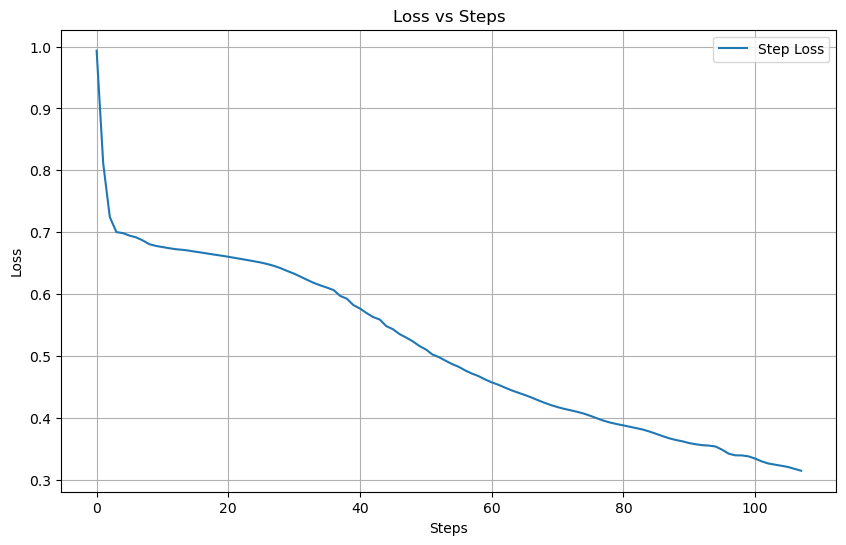

In [43]:
ds_id = 'gallstone_female'  #'gallstone_male'
all_data = gallstone_female  #'gallstone_male

y = all_data['Gallstone Status']
X = all_data.drop(columns=['Gallstone Status'])
num_class = y.nunique()
missing_rate = X.isna().sum().mean()
print('Numerical features missing rate:', missing_rate)
# print(y)
if missing_rate != 0:
    X.fillna(X.median(), inplace=True)

# Calculate class weights for multi-class classification
class_counts = y.value_counts().sort_index()
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
weight = torch.tensor(class_weights.values, dtype=torch.float32)
print('Class weights:', weight)

input_size = X.shape[1]
results, data_add = train_on_full_data(
    X.columns, X.values, y.values, MLP, input_size=input_size, epochs=epochs, batch_size=batch_size, lr=lr,weight=None, regularization=regularization, reg_lambda = reg_lambda)

output_dir = f"result/{ds_id}"
os.makedirs(output_dir, exist_ok=True)

result_file = f"{output_dir}/results_epochs{epochs}_lr{lr}_batch{batch_size}_{regularization}_{reg_lambda}_weight_6432168_0.9.pkl"
with open(result_file, "wb") as f1:
    pickle.dump(results, f1)

print('dataset_id', ds_id,'epoch:',epochs, 'lr',lr,'batch',batch_size)

# Save step loss plot
step_loss_plot_file = f"{output_dir}/loss_vs_steps_epochs{epochs}_lr{lr}_batch{batch_size}_{regularization}_{reg_lambda}_weight_6432168_0.9.png"
plot_step_loss(results["step_losses"], save_path=step_loss_plot_file)

In [9]:
output_dir = f"result/gallstone_male"
with open(f"{output_dir}/results_epochs1000_lr0.001_batch128_None_None_weight_6432168_0.9.pkl", "rb") as f1:
    results = pickle.load(f1)
data = results['updated_dataset']

In [10]:
data

,Age,Height,Weight,Body Mass Index (BMI),Total Body Water (TBW),Extracellular Water (ECW),Intracellular Water (ICW),Extracellular Fluid/Total Body Water (ECF/TBW),Total Body Fat Ratio (TBFR) (%),Lean Mass (LM) (%),...,Aspartat Aminotransferaz (AST),Alanin Aminotransferaz (ALT),Alkaline Phosphatase (ALP),Creatinine,Glomerular Filtration Rate (GFR),C-Reactive Protein (CRP),Hemoglobin (HGB),Vitamin D,mlp_acc,class
0,50.0,185.0,92.8,27.1,52.9,21.2,31.7,40.00,19.20,80.84,...,20.0,22.0,87.0,0.820,112.47,0.00,16.00,33.00,0.042518,0
1,61.0,171.0,91.1,31.2,47.2,20.1,27.1,43.00,27.30,72.67,...,18.0,14.0,66.0,1.250,65.51,0.00,16.20,30.20,0.060244,0
2,41.0,168.0,67.7,24.0,41.4,17.0,24.4,41.00,15.80,84.19,...,20.0,12.0,34.0,1.020,94.10,0.00,15.40,35.40,0.175845,0
3,42.0,178.0,89.6,28.3,51.4,20.0,31.4,39.00,20.00,80.02,...,27.0,54.0,71.0,0.820,112.47,0.00,16.80,40.60,0.006794,0
4,96.0,155.0,49.0,20.4,34.0,15.7,18.3,46.00,6.30,93.67,...,13.0,13.0,60.0,1.460,43.74,0.00,11.00,45.80,0.005065,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,55.0,177.0,106.3,33.9,50.6,21.9,28.7,43.00,32.20,67.83,...,17.0,15.0,70.5,0.715,100.70,0.65,14.15,17.75,0.573288,1
106,59.0,172.0,78.8,26.6,42.1,18.2,23.9,43.00,23.30,76.65,...,17.0,16.0,92.0,1.240,66.90,0.20,14.50,36.90,0.218655,1
107,56.0,171.0,73.1,25.0,42.4,18.0,24.4,42.00,18.40,81.53,...,13.0,18.0,46.0,1.200,86.26,0.00,14.60,19.40,0.488004,1
108,49.0,178.0,88.8,28.0,47.6,20.0,28.0,42.01,24.66,75.23,...,28.0,50.0,90.0,0.980,94.50,6.20,16.50,8.30,0.573288,1


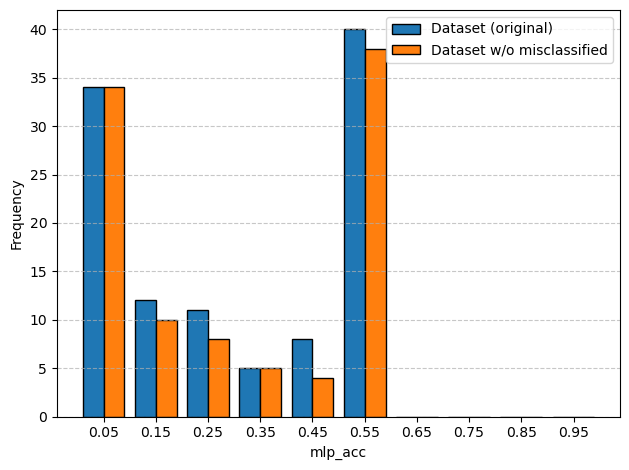

In [11]:
data = data.drop(columns=['Unnamed: 0'], errors='ignore')

condition1 = (data['class'] == 1) & (data['mlp_acc'] < 0.5)
condition2 = (data['class'] == 0) & (data['mlp_acc'] > 0.5)

filtered_data = data[~(condition1 | condition2)]
filtered_data.to_csv(f'{directory}/remove_wrong.csv')

bins = np.linspace(0, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2
bar_width = 0.04
# print(bin_centers)

original_counts, _ = np.histogram(data['mlp_acc'], bins=bins)
filtered_counts, _ = np.histogram(filtered_data['mlp_acc'], bins=bins)

positions_original = bin_centers - bar_width / 2
positions_filtered = bin_centers + bar_width / 2

plt.bar(positions_original, original_counts, width=bar_width, label='Dataset (original)', edgecolor='black')
plt.bar(positions_filtered, filtered_counts, width=bar_width, label='Dataset w/o misclassified', edgecolor='black')
plt.xlabel('mlp_acc')
plt.ylabel('Frequency')
plt.xticks(bin_centers)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# CAUSAL

## directlingam

In [9]:
import lingam
from lingam import DirectLiNGAM
from sklearn.utils import check_array, check_scalar
from lingam.utils import make_dot

In [34]:
def run_directlingam(ds_id, keep_c, data):
    yy = data[['class', 'mlp_acc']]
    data = data.drop(columns=['Unnamed: 0', 'class', 'mlp_acc'], errors='ignore')
    data = pd.concat([data, yy[keep_c]], axis=1)

    data.fillna(data.median(), inplace=True)

    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data)

    save_dir = f"result/{ds_id}"
    
    model = DirectLiNGAM(random_state = 42)#, measure="kernel"

    model.fit(data_normalized)
    W_df = pd.DataFrame(model.adjacency_matrix_, index=data.columns, columns=data.columns)

    W_df.to_csv(f'{save_dir}/LiNGAM_{drop_c}_{ds_id}_stand.csv')
    print(f'w_df saved in the {save_dir}/LiNGAM_{drop_c}_{ds_id}_stand.csv')
    return W_df

In [35]:
ds_id = 'gallstone_male' #'gallstone_female'
keep_c = 'class'
W_df = run_directlingam(ds_id, keep_c, data)

w_df saved in the result/gallstone_male/LiNGAM_mlp_acc_gallstone_male_stand.csv


In [6]:
W_df = pd.read_csv(f'LiNGAM_mlp_acc_gallstone_male_stand.csv')#result/{ds_id}/
W_df.index = W_df['Unnamed: 0']
W_df.index.name = None
W_df = W_df.drop(columns = ['Unnamed: 0'])
W_df

,Age,Height,Weight,Body Mass Index (BMI),Total Body Water (TBW),Extracellular Water (ECW),Intracellular Water (ICW),Extracellular Fluid/Total Body Water (ECF/TBW),Total Body Fat Ratio (TBFR) (%),Lean Mass (LM) (%),...,Triglyceride,Aspartat Aminotransferaz (AST),Alanin Aminotransferaz (ALT),Alkaline Phosphatase (ALP),Creatinine,Glomerular Filtration Rate (GFR),C-Reactive Protein (CRP),Hemoglobin (HGB),Vitamin D,mlp_acc
Age,0.000000,0.000000,0.000000,0.000000,0.000000,-0.630396,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
Height,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
Weight,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
Body Mass Index (BMI),0.000000,-0.393181,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
Total Body Water (TBW),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
Extracellular Water (ECW),0.000000,0.334840,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
Intracellular Water (ICW),0.058569,0.321232,0.000000,0.806840,-1.407411,0.259389,0.0,-0.222124,-0.466831,0.000000,...,0.000000,-0.021995,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-0.029833
Extracellular Fluid/Total Body Water (ECF/TBW),0.000000,-0.421958,0.000000,-1.082502,-0.663041,2.800278,0.0,0.000000,0.000000,-0.876590,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
Total Body Fat Ratio (TBFR) (%),0.000000,-0.096629,0.000000,0.000000,0.000000,-0.323787,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
Lean Mass (LM) (%),0.000000,0.000000,0.000000,0.000000,0.000000,-0.068798,0.0,0.000000,-0.993492,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000


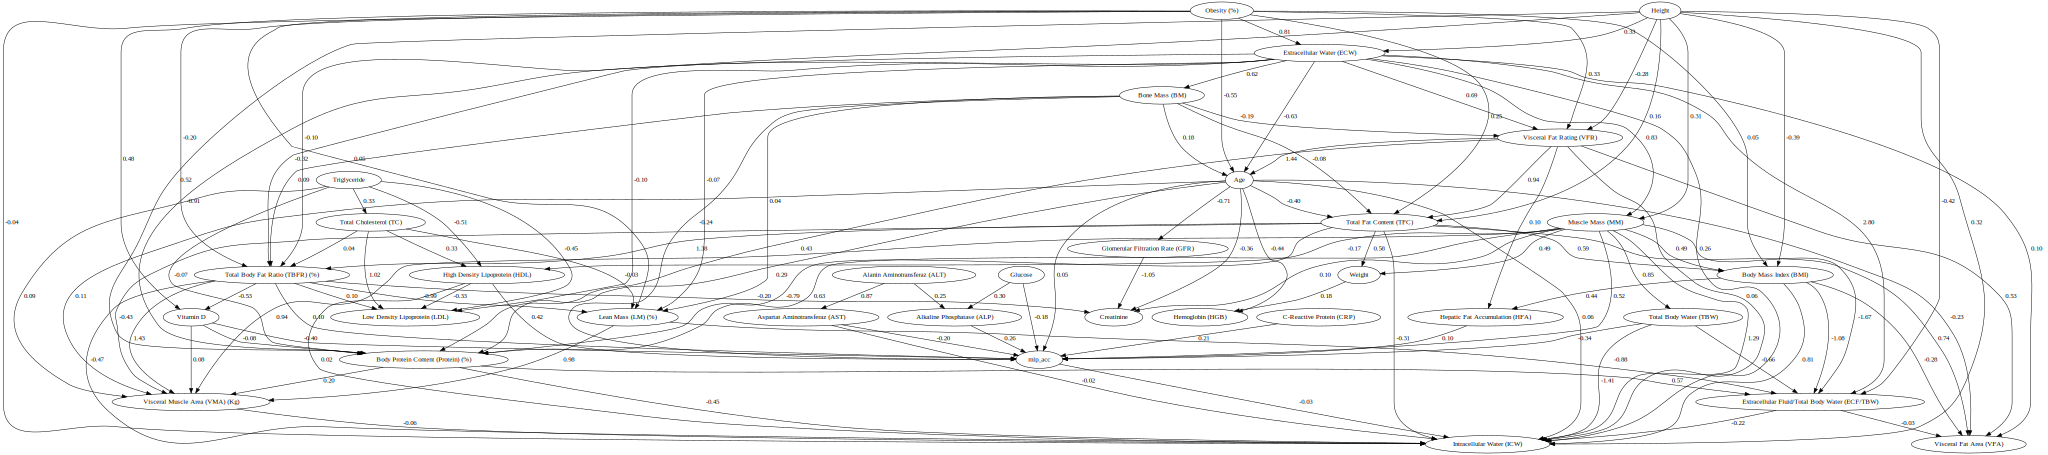

In [10]:
dag = make_dot(W_df, labels=W_df.index.to_list())
dag

## notears_mlp

In [113]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import NotearsNonlinear

In [114]:
def run_notearsmlp(ds_id, keep_c, data):
    yy = data[['class', 'mlp_acc']]
    data = data.drop(columns=['Unnamed: 0', 'class', 'mlp_acc'], errors='ignore')
    data = pd.concat([data, yy[keep_c]], axis=1)

    data.fillna(data.median(), inplace=True)

    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data)

    save_dir = f"result/{ds_id}"

    model = NotearsNonlinear(model_type = 'mlp', device_type='gpu', device_ids = '0')

    model.learn(data_normalized)
    W_df = pd.DataFrame(model.causal_matrix, index=data.columns, columns=data.columns)
    w = pd.DataFrame(model.weight_causal_matrix, index = data.columns, columns = data.columns)

    W_df.to_csv(f'{save_dir}/Notearsmlp_{keep_c}_{ds_id}_stand.csv')
    w.to_csv(f'{save_dir}/Notearsmlp_{keep_c}_{ds_id}_stand_weight.csv')
    print(f'w saved in the {save_dir}')
    
    return W_df

In [115]:
ds_id = 'gallstone_female'
keep_c = 'mlp_acc'
W_df = run_notearsmlp(ds_id, keep_c, data)

2025-05-15 14:04:54,875 - /home/cida-lab-2/miniconda3/envs/functorch_cud11/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:135] - INFO: GPU is available.
2025-05-15 14:04:54,897 - /home/cida-lab-2/miniconda3/envs/functorch_cud11/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:237] - INFO: [start]: n=107, d=33, iter_=100, h_=1e-08, rho_=1e+16
2025-05-15 14:08:36,373 - /home/cida-lab-2/miniconda3/envs/functorch_cud11/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:249] - INFO: FINISHED


w saved in the result/gallstone_female


In [116]:
ds_id = 'gallstone_female'
keep_c = 'class'
W_df = run_notearsmlp(ds_id, keep_c, data)

2025-05-15 14:08:36,402 - /home/cida-lab-2/miniconda3/envs/functorch_cud11/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:135] - INFO: GPU is available.
2025-05-15 14:08:36,407 - /home/cida-lab-2/miniconda3/envs/functorch_cud11/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:237] - INFO: [start]: n=107, d=33, iter_=100, h_=1e-08, rho_=1e+16
2025-05-15 14:16:33,582 - /home/cida-lab-2/miniconda3/envs/functorch_cud11/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:249] - INFO: FINISHED


w saved in the result/gallstone_female


In [80]:
def bigger(weight_matrix):
    """
    Enforces one-directional causal relationships in the weight matrix
    while keeping the original weight values.

    Parameters:
    - weight_matrix (numpy.ndarray): The original weight matrix from NOTEARS (n x n).

    Returns:
    - numpy.ndarray: The processed weight matrix with one direction enforced.
    """
    # Ensure the matrix is square
    assert weight_matrix.shape[0] == weight_matrix.shape[1], "Weight matrix must be square."

    # Create a copy of the weight matrix
    one_direction_matrix = weight_matrix.copy()

    # Enforce one direction
    for i in range(weight_matrix.shape[0]):
        for j in range(i + 1, weight_matrix.shape[1]):  # Only process upper triangular part
            if weight_matrix[i, j] > weight_matrix[j, i]:
                one_direction_matrix[j, i] = 0  # Keep W[i, j] and remove W[j, i]
            else:
                one_direction_matrix[i, j] = 0  # Keep W[j, i] and remove W[i, j]

    return one_direction_matrix

In [84]:
bw = bigger(w.values)
bw_df = pd.DataFrame(bw, index = w.columns, columns = w.columns)

In [85]:

bw_df

,preg,plas,pres,skin,insu,mass,pedi,age,mlp_acc
preg,0.000000,0.011052,0.000003,0.000000,0.0,0.094427,0.105777,0.000000,0.324601
plas,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.227227
pres,0.000000,0.166251,0.000000,0.000000,0.0,0.360626,0.000000,1.030055,0.093919
skin,0.108150,0.106915,0.571753,0.000000,0.0,0.981041,0.292852,0.348907,0.115826
insu,0.043582,0.781267,0.000000,1.543582,0.0,0.014651,0.226411,0.000000,0.030653
mass,0.000000,0.000013,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
pedi,0.000000,0.000008,0.000000,0.000000,0.0,0.000000,0.000000,0.000006,0.000000
age,1.677714,0.520597,0.000000,0.000000,0.0,0.027464,0.000000,0.000000,0.071394
mlp_acc,0.000000,0.000000,0.000000,0.000000,0.0,0.779427,0.557474,0.000000,0.000000


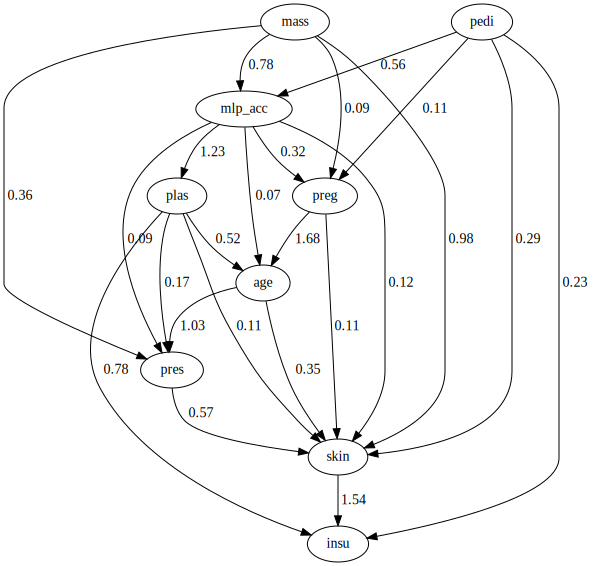

In [93]:
cause = bw_df[bw_df > 0.05].fillna(0)
dag = make_dot(cause, labels=cause.index.to_list())
#     print(data.values*mask)
dag